In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


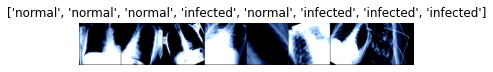

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [16]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of RESNET18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential()
features = list(resnet18.fc)
print(features)

[]


In [0]:
# Freeze training for all layers
ct = 0
for child in resnet18.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False

In [0]:
features.extend([nn.Linear(num_features, 190)]) # 9*10 + 100

In [0]:
features.extend([nn.Linear(190, len(class_names))])

In [21]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [26]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')

print('Finished Training')


0it [00:00, ?it/s]

cuda:0



Train Epoch: 0 [0/12000 (0%)]	Loss: 0.732133: : 0it [00:07, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.732133: : 1it [00:07,  7.20s/it]
Train Epoch: 0 [8/12000 (0%)]	Loss: 0.649495: : 1it [00:13,  7.20s/it]
Train Epoch: 0 [8/12000 (0%)]	Loss: 0.649495: : 2it [00:13,  7.00s/it]
Train Epoch: 0 [16/12000 (0%)]	Loss: 0.753363: : 2it [00:19,  7.00s/it]
Train Epoch: 0 [16/12000 (0%)]	Loss: 0.753363: : 3it [00:19,  6.67s/it]
Train Epoch: 0 [24/12000 (0%)]	Loss: 0.524729: : 3it [00:24,  6.67s/it]
Train Epoch: 0 [24/12000 (0%)]	Loss: 0.524729: : 4it [00:24,  6.20s/it]
Train Epoch: 0 [32/12000 (0%)]	Loss: 0.563038: : 4it [00:30,  6.20s/it]
Train Epoch: 0 [32/12000 (0%)]	Loss: 0.563038: : 5it [00:30,  6.14s/it]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.749857: : 5it [00:43,  6.14s/it]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.749857: : 6it [00:43,  8.15s/it]
Train Epoch: 0 [48/12000 (0%)]	Loss: 0.741716: : 6it [00:49,  8.15s/it]
Train Epoch: 0 [48/12000 (0%)]	Loss: 0.741716: : 7it [00:49,  7.36s/it]

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


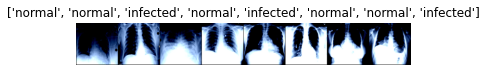

In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [28]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected normal normal normal normal infected
Ground Truth:  normal normal infected normal infected normal normal infected


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %
